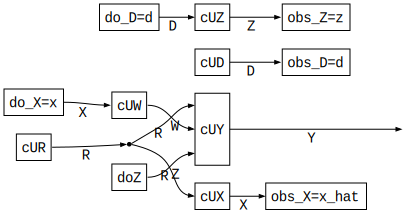

In [39]:


using Catlab
using Catlab.Theories
using Catlab.CategoricalAlgebra
using Catlab.WiringDiagrams
using Catlab.WiringDiagrams.DirectedWiringDiagrams
using Catlab.Programs
using Catlab.Graphics
using Catlab.Graphics: Graphviz, to_graphviz

include("admg_compile.jl")
include("id_cf.jl")
include("simplify_cf.jl")
include("utils.jl")


fig_15b_model = ConfoundedModel(
    [
        :X => :W,
        :W => :Y,
        :D => :Z,
        :Z => :Y
    ],
    Dict(
        :R => [:X,:Y]
    )
)

display_var = Set([:D, :Z, :X, :W, :Y])

base_scm = graph_b_to_scm(fig_15b_model; outputs=display_var)

q1 = CounterfactualQuery(
    :World1, 
    Dict(:X => :x), # Interventions
    Dict{Symbol, Symbol}(),    # No Observations here
    [:Y]              # Output Y
)

q2 = CounterfactualQuery(
    :World2, 
    Dict(),                       # No Interventions
    Dict(:X => :x_hat, :D => :d),            # Observations
    Symbol[]
)

q3 = CounterfactualQuery(
    :World2, 
    Dict(:D => :d),
    Dict(:Z => :z),            # Observations
    Symbol[]
)

queries = [q1, q2, q3]

full_wd = build_multiverse(base_scm, queries)

draw(add_junctions(full_wd))



simplified_wd = full_wd
drop_discard_branches!(simplified_wd)
merge_identical_deterministic_boxes(simplified_wd)
replace_fx_with_cx!(simplified_wd)
draw(add_junctions(simplified_wd))

In [20]:
simplified_wd

WiringDiagram([], [:Y], 
[ -2 => {inputs},
  -1 => {outputs},
  1 => Box(:cUY, [:R,:W,:Z], [:Y]),
  2 => Box(:cUX, [:R], [:X]),
  3 => Box(Symbol("obs_X=x"), [:X], []),
  4 => Box(Symbol("obs_D=d"), [:D], []),
  5 => Box(:doZ, [], [:Z]),
  6 => Box(Symbol("do_D=d"), [], [:D]),
  7 => Box(:cUD, [], [:D]),
  8 => Box(:cUR, [], [:R]),
  9 => Box(:cUW, [:X], [:W]),
  10 => Box(Symbol("obs_Z=z"), [:Z], []),
  11 => Box(:cUZ, [:D], [:Z]),
  12 => Box(Symbol("do_X=doX_"), [], [:X]) ],
[ Wire((6,1) => (11,1)),
  Wire((5,1) => (1,3)),
  Wire((2,1) => (3,1)),
  Wire((11,1) => (10,1)),
  Wire((8,1) => (1,1)),
  Wire((9,1) => (1,2)),
  Wire((7,1) => (4,1)),
  Wire((12,1) => (9,1)),
  Wire((8,1) => (2,1)),
  Wire((1,1) => (-1,1)) ])

---- Step 4.1 on R-fragment #1 ----
  Fragment 1, var Z, case2 = case2b_rewritten
  Fragment 1, var W, case2 = case2a_do_nothing
  Fragment 1, var X, case1 = case1b_detected
  Fragment 1, var Y, case1 = case1a_do_nothing
---- Step 4.1 on R-fragment #2 ----
  Fragment 2, var D, case1 = case1b_detected
---- Step 4.1 on R-fragment #3 ----
  Fragment 3, var W, case1 = case1a_do_nothing
  Fragment 3, var X, case2 = case2b_rewritten
---- Step 4.1 on R-fragment #4 ----
  Fragment 4, var Z, case1 = case1b_detected
  Fragment 4, var D, case2 = case2b_rewritten
---- Step 4.2: collapsing R-fragment #1 ----
---- Step 4.2: collapsing R-fragment #2 ----
---- Step 4.2: collapsing R-fragment #3 ----
---- Step 4.2: collapsing R-fragment #4 ----


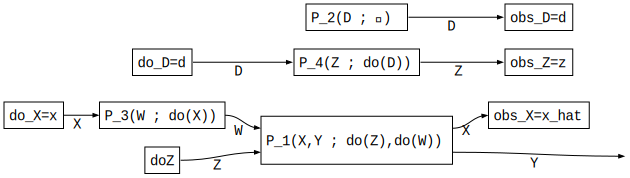

In [40]:
wd = id_cf_step4!(simplified_wd, display_var)
draw(add_junctions(wd))

In [ ]:
directed = [("X","W"), ("W","Y"), ("Z","Y"), ("D","Z")]

res2 = id_cf_step5(
    wd;
    output_vars=["Y"],
    simplify=true,
    enable_cfid_rules=true,
    directed_edges=directed,
    var2sym=Dict("Y"=>"y","W"=>"w","D"=>"d","Z"=>"z","X"=>"x"),
    obs_value_rename=Dict("x_hat"=>"x'"),
    data_mode=:interventions,
    mix_var="D",
    mix_sym="d^*",
    mix_target_var="Z",
    anchor_var="X"
)

println(res2.data_tex)


DATA (interventions):
\frac{\sum_{w,d^*} P(z|do(d))P(x',y|do(z,w))P(d)P(w|do(x))P(d^*)}{\sum_{d^*} P(x')P(z|do(d^*))P(d^*)}


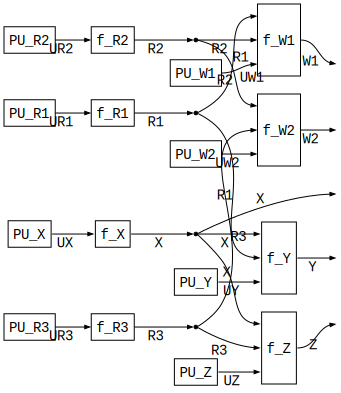

In [23]:
model_2 = ConfoundedModel(
    [
        :X => :Y,
        :X => :Z,
    ],
    Dict(
        :R1 => [:Y,:W1],
        :R2 => [:W1, :W2],
        :R3 => [:W2, :Z],
    )
)
display_var = Set([:X, :Y, :Z, :W1, :W2])
base_scm = graph_b_to_scm(model_2; outputs=display_var)

draw(add_junctions(base_scm))



In [24]:
q1 = CounterfactualQuery(
    :World1, 
    Dict(:X => :doX), # Interventions
    Dict{Symbol, Symbol}(),    # No Observations here
    [:Y,:Z, :W1, :W2]              # Output Y
)
queries = [q1]

full_wd = build_multiverse(base_scm, queries)
full_wd = replace_fx_with_cx!(full_wd)
full_wd = drop_discard_branches!(full_wd)
draw(add_junctions(full_wd))
show_r_fragments(full_wd)

Found 1 R-fragments:
  Fragment 1: cUR3, cUR1, cUR2, cUW1, cUW2, cUZ, cUY


1-element Vector{Vector{Int64}}:
 [1, 4, 5, 2, 3, 8, 7]

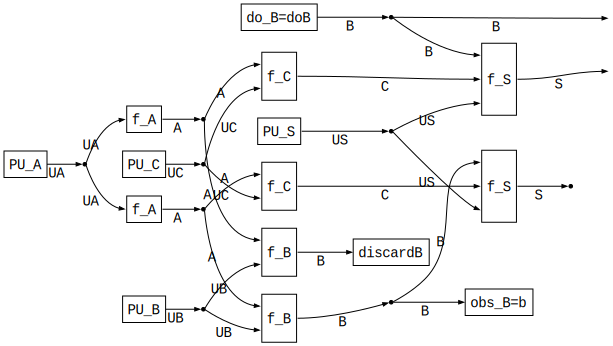

In [25]:
model_party = ConfoundedModel(
  [
    :A => :B,
    :A => :C,
    :B => :S,
    :C => :S,
  ],
  Dict()
)

display_var = Set([:B, :S])

base_scm = graph_b_to_scm(model_party; outputs=display_var)

draw(add_junctions(base_scm))
q_real = CounterfactualQuery(
    :Real, 
    Dict(),              # no interventions in real world
    Dict(:B => :b),           # observe B
    []                 # output
)

q_cf = CounterfactualQuery(
    :CF,
    Dict(:B => :doB),    # do(B=1)
    Dict{Symbol, Symbol}(),       # no observations in cf world
    [:B, :S]             # output
)

queries = [q_real, q_cf]

full_wd = build_multiverse(base_scm, queries)
draw(add_junctions(full_wd))




In [26]:

simplified_wd = full_wd
drop_discard_branches!(simplified_wd)
merge_identical_deterministic_boxes(simplified_wd)
replace_fx_with_cx!(simplified_wd)
draw(add_junctions(simplified_wd))
simplified_wd

WiringDiagram([], [:B,:S], 
[ -2 => {inputs},
  -1 => {outputs},
  1 => Box(Symbol("obs_B=b"), [:B], []),
  2 => Box(:cUS, [:C,:B], [:S]),
  3 => Box(Symbol("do_B=doB"), [], [:B]),
  4 => Box(:cUC, [:A], [:C]),
  5 => Box(:cUA, [], [:A]),
  6 => Box(:cUB, [:A], [:B]) ],
[ Wire((4,1) => (2,1)),
  Wire((3,1) => (2,2)),
  Wire((5,1) => (4,1)),
  Wire((5,1) => (6,1)),
  Wire((6,1) => (1,1)),
  Wire((3,1) => (-1,1)),
  Wire((2,1) => (-1,2)) ])

---- Step 4.1 on R-fragment #1 ----
  Fragment 1, var B, case2 = case2b_rewritten
  Fragment 1, var S, case1 = case1a_do_nothing
---- Step 4.1 on R-fragment #2 ----
---- Step 4.1 on R-fragment #3 ----
---- Step 4.1 on R-fragment #4 ----
  Fragment 4, var B, case1 = case1b_detected
---- Step 4.2: collapsing R-fragment #1 ----
---- Step 4.2: collapsing R-fragment #2 ----
---- Step 4.2: collapsing R-fragment #3 ----
---- Step 4.2: collapsing R-fragment #4 ----


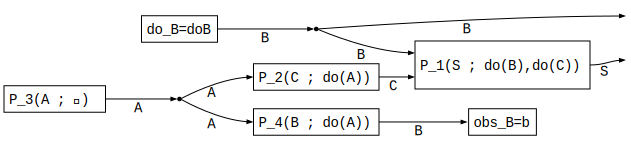

In [27]:
wd = id_cf_step4!(simplified_wd, display_var)
draw(add_junctions(wd))


---- Step 4.1 on R-fragment #1 ----
  Fragment 1, var A, case2 = case2b_rewritten
  Fragment 1, var H, case1 = case1a_do_nothing
---- Step 4.1 on R-fragment #2 ----
  Fragment 2, var A, case1 = case1b_detected
---- Step 4.2: collapsing R-fragment #1 ----
---- Step 4.2: collapsing R-fragment #2 ----


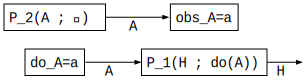

In [28]:
model_fig8 = ConfoundedModel(
    [
        :A => :H
    ],
    Dict()
)
query_fig8 = [
    CounterfactualQuery(
        :w_actual,
        Dict(),
        Dict(:A => :a),
        Symbol[]
    ),

    CounterfactualQuery(
        :w_doA,
        Dict(:A => :a),
        Dict{Symbol, Symbol}(),
        [:H]
    )
]

display_var = Set([:A, :H])

base_scm = graph_b_to_scm(model_fig8; outputs=display_var)
draw(add_junctions(base_scm))

full_wd = build_multiverse(base_scm, query_fig8)
simplified_wd = full_wd
drop_discard_branches!(simplified_wd)
merge_identical_deterministic_boxes(simplified_wd)
replace_fx_with_cx!(simplified_wd)
draw(add_junctions(simplified_wd))
wd = id_cf_step4!(simplified_wd, display_var)
draw(add_junctions(wd))


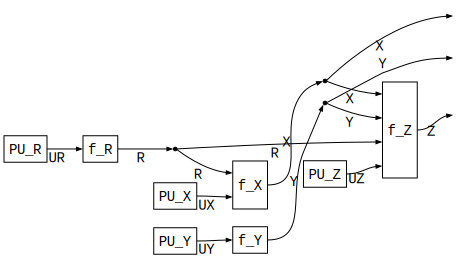

In [29]:
model_fig6b = ConfoundedModel(
    [
        :X => :Z,
        :Y => :Z,
    ],
    Dict(
        :R => [:X, :Z]
    )
)
query_fig6b = [
    CounterfactualQuery(
        :w_doX,
        Dict(:X => :x),
        Dict(:Z => :z),
        [:Y]
    )
]
display_var = Set([:X, :Y, :Z])

base_scm = graph_b_to_scm(model_fig6b; outputs=display_var)
draw(add_junctions(base_scm))

# full_wd = build_multiverse(base_scm, query_fig6b)
# simplified_wd = full_wd
# drop_discard_branches!(simplified_wd)
# merge_identical_deterministic_boxes(simplified_wd)
# replace_fx_with_cx!(simplified_wd)
# draw(add_junctions(simplified_wd))
# wd = id_cf_step4!(simplified_wd, display_var)
# draw(add_junctions(wd))

---- Step 4.1 on R-fragment #1 ----
  Fragment 1, var Y2, case1 = case1a_do_nothing
  Fragment 1, var X, case2 = case2b_rewritten
  Fragment 1, var Y1, case1 = case1a_do_nothing
---- Step 4.1 on R-fragment #2 ----
  Fragment 2, var X, case1 = case1b_detected
---- Step 4.2: collapsing R-fragment #1 ----
---- Step 4.2: collapsing R-fragment #2 ----


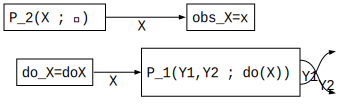

In [30]:
model_cf5 = ConfoundedModel(
    [
        :X => :Y1,
        :X => :Y2
    ],
    Dict(
        :R => [:Y1, :Y2]
    )
)
query_cf5 = [
    CounterfactualQuery(
        :w_actual,
        Dict(),
        Dict(:X => :x),
        Symbol[]
    ),

    CounterfactualQuery(
        :w_doX,
        Dict(:X => :doX),
        Dict{Symbol, Symbol}(),
        [:Y1, :Y2]
    )
]
display_var = Set([:X, :Y1, :Y2])

base_scm = graph_b_to_scm(model_cf5; outputs=display_var)
draw(add_junctions(base_scm))

full_wd = build_multiverse(base_scm, query_cf5)
simplified_wd = full_wd
drop_discard_branches!(simplified_wd)
merge_identical_deterministic_boxes(simplified_wd)
replace_fx_with_cx!(simplified_wd)
draw(add_junctions(simplified_wd))
wd = id_cf_step4!(simplified_wd, display_var)
draw(add_junctions(wd))


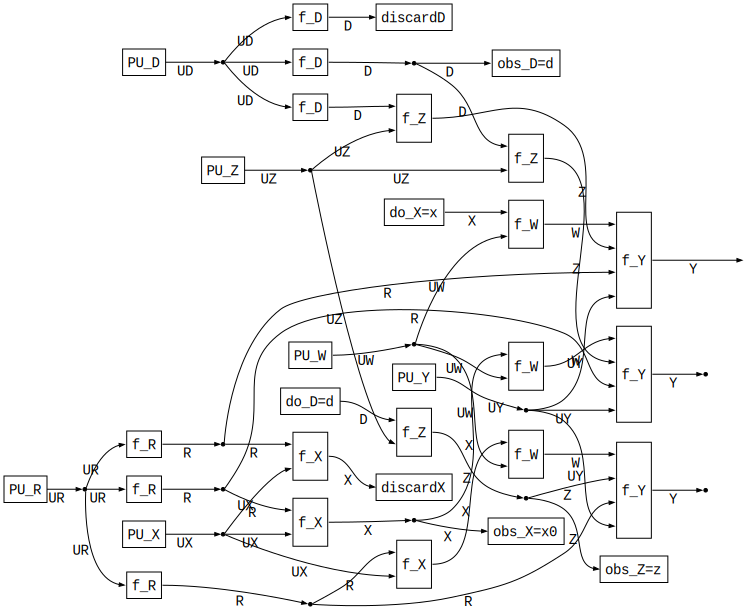

In [31]:

model = ConfoundedModel(
    [
        :X => :W,
        :W => :Y,
        :D => :Z,
        :Z => :Y
    ],
    Dict(:R => [:X, :Y])
)
base = graph_b_to_scm(model)

queries = [
    CounterfactualQuery(:World1, Dict(:X => :x), Dict{Symbol,Symbol}(), [:Y]),
    CounterfactualQuery(:World2, Dict(), Dict(:X => :x0, :D => :d), Symbol[]),
    CounterfactualQuery(:World3, Dict(:D => :d), Dict(:Z => :z), Symbol[]),
]

wd = build_multiverse(base, queries)
draw(add_junctions(wd))

In [32]:
    wd = WiringDiagram([], Any[])
    display_vars = Set([:X, :U])

    cR = WD.add_box!(wd, Box(:cR, Any[], Any[:U]))
    cX = WD.add_box!(wd, Box(:cX, Any[:U], Any[:X]))
    WD.add_wire!(wd, (cR,1)=>(cX,1))
    id_cf_step41!(wd, display_vars; verbose=false)


1-element Vector{Vector{Int64}}:
 [1, 2]

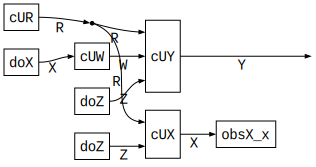

In [33]:

@present CausalR(FreeSymmetricMonoidalCategory) begin
  (R, X, W, Z, Y, D)::Ob

  cUR::Hom(munit(), R)
  cUX::Hom(R ⊗ Z, X)
  cUW::Hom(X, W)
  cUY::Hom(R ⊗ W ⊗ Z, Y)

  doX::Hom(munit(), X)
  doZ::Hom(munit(), Z)

  obsX_x::Hom(X, munit())
end

prog_overall = @program CausalR () begin
  r  = cUR()

  z_for_cx = doZ()
  x_obs = cUX(r, z_for_cx)
  obsX_x(x_obs)

  x_do = doX()
  w    = cUW(x_do)

  z_for_y = doZ()
  y = cUY(r, w, z_for_y)

  return y
end


draw(prog_overall)
draw(add_junctions(prog_overall))

In [35]:
display_var = Set([:Z, :X, :W, :Y])
r_frags = id_cf_step41!(prog_overall, display_var)
# wd = id_cf_step42!(prog_overall, r_frags)

---- Step 4.1 on R-fragment #1 ----
  Fragment 1, var Z, case2 = case2b_rewritten
  Fragment 1, var W, case2 = skip_no_X_input
  Fragment 1, var X, case1 = case1b_detected
  Fragment 1, var Y, case2 = skip_no_X_input
---- Step 4.1 on R-fragment #2 ----
  Fragment 2, var W, case1 = case1a_do_nothing
  Fragment 2, var X, case2 = case2b_rewritten


2-element Vector{Vector{Int64}}:
 [1, 3, 8]
 [6]

In [36]:
model = ConfoundedModel(
    [
        :X => :W,
        :W => :Y,
        :D => :Z,
        :Z => :Y
    ],
    Dict(:R => [:X, :Y])
)
base = graph_b_to_scm(model)

queries = [
    CounterfactualQuery(:World1, Dict(:X => :x), Dict{Symbol,Symbol}(), [:Y]),
    CounterfactualQuery(:World2, Dict(), Dict(:X => :x0, :D => :d), Symbol[]),
    CounterfactualQuery(:World3, Dict(:D => :d), Dict(:Z => :z), Symbol[]),
]

wd = build_multiverse(base, queries)
drop_discard_branches!(wd)
merge_identical_deterministic_boxes(wd)
replace_fx_with_cx!(wd)


WiringDiagram([], [:Y], 
[ -2 => {inputs},
  -1 => {outputs},
  1 => Box(:cUY, [:R,:W,:Z], [:Y]),
  2 => Box(:cUX, [:R], [:X]),
  3 => Box(Symbol("obs_X=x0"), [:X], []),
  4 => Box(Symbol("obs_D=d"), [:D], []),
  5 => Box(:doZ, [], [:Z]),
  6 => Box(Symbol("do_D=d"), [], [:D]),
  7 => Box(:cUD, [], [:D]),
  8 => Box(:cUR, [], [:R]),
  9 => Box(:cUW, [:X], [:W]),
  10 => Box(Symbol("obs_Z=z"), [:Z], []),
  11 => Box(:cUZ, [:D], [:Z]),
  12 => Box(Symbol("do_X=x"), [], [:X]) ],
[ Wire((6,1) => (11,1)),
  Wire((5,1) => (1,3)),
  Wire((2,1) => (3,1)),
  Wire((11,1) => (10,1)),
  Wire((8,1) => (1,1)),
  Wire((9,1) => (1,2)),
  Wire((7,1) => (4,1)),
  Wire((12,1) => (9,1)),
  Wire((8,1) => (2,1)),
  Wire((1,1) => (-1,1)) ])